In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
from src.evaluation.dm_test import dm_test
os.chdir('./notebooks')



# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [46]:
# Input 
start_date = "2016-01-01"
end_date = "2021-07-20"
ntest = 20
# janela = 19
bolsa = '^BVSP'

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


In [47]:
df_ibovespa = yf.download(bolsa, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


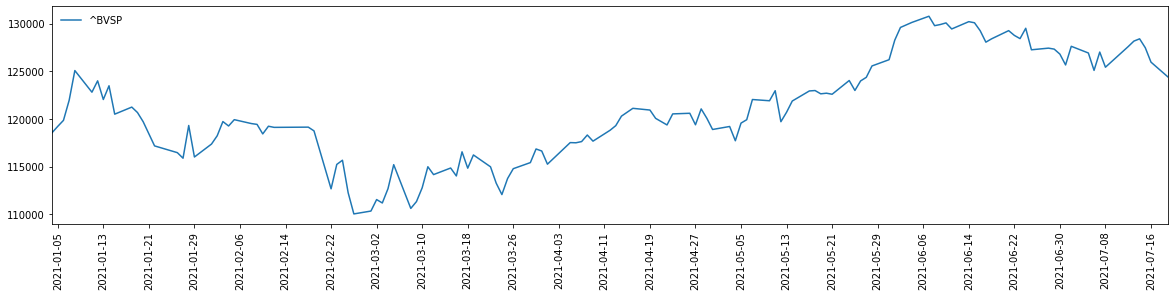

In [48]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label=bolsa)

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

In [49]:
df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100

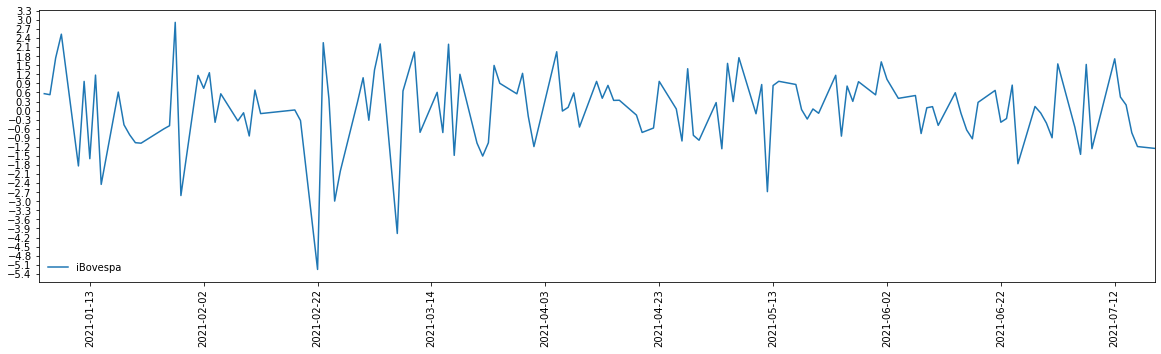

In [50]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()

ax.plot(df_ibovespa["rt"], label="iBovespa")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
# ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

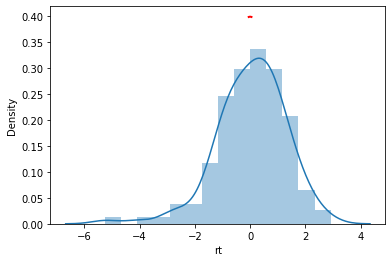

In [51]:
ax =sns.distplot(df_ibovespa['rt'], kde=True, norm_hist=True)
# calculate the pdf over a range of values
xx = np.arange(-0.05, +0.05, 0.001)                                                   
yy = stats.norm.pdf(xx)                                                         
# and plot on the same axes that seaborn put the histogram
ax.plot(xx, yy, 'r', lw=2) 

count    132.000000
mean       0.036409
std        1.262550
min       -5.255816
25%       -0.724513
50%        0.118168
75%        0.862132
max        2.918624
Name: rt, dtype: float64

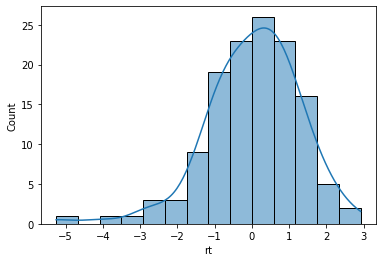

In [52]:
sns.histplot(data=df_ibovespa, x="rt", kde=True);
df_ibovespa['rt'].describe().T

In [53]:
shapiro_stat, shapiro_p_valor = stats.shapiro(df_ibovespa['rt'][1:])

In [54]:
print('O valor de estatístico de Shapiro-Wilk = ', str(shapiro_stat))
print('O valor de p de Shapiro-Wilk = ', str(shapiro_p_valor))

O valor de estatístico de Shapiro-Wilk =  0.9627072215080261
O valor de p de Shapiro-Wilk =  0.0011094458168372512


In [55]:
if shapiro_p_valor > 0.05:
    print('Com 95% de confiança, os dados são similares a uma distribuição normal segundo o teste de Shapiro-Wilk')
else:
    print('Com 95% de confiança, os dados não são similares a uma distribuição normal segundo o teste de Shapiro-Wilk')

Com 95% de confiança, os dados não são similares a uma distribuição normal segundo o teste de Shapiro-Wilk


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [56]:
# for cont in np.arange(ntest):
#     X_train = df_ibovespa[:-ntest+cont]
#     X_test = df_ibovespa[-ntest+cont:ntotal-ntest+1+cont]
    

#     print(f""" 
#     cont : {cont}
#     X_train: {X_train.shape} {X_train.index[-1]}
#     X_test: {X_test.shape} {X_test.index[-1]}\n""")

In [57]:
ntotal = df_ibovespa.shape[0]
resultado = {}

for cont in np.arange(ntest):
    X_train = df_ibovespa[:-ntest+cont]
    X_test = df_ibovespa[-ntest+cont:ntotal-ntest+1+cont]
    
    # X_test = df_ibovespa[-1:]

    # print(f""" 
    # cont : {cont}
    # X_train: {X_train.shape} {X_train.index[-1]}
    # X_test: {X_test.shape} {X_test.index[-1]}\n""")

    X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
    X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
    df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100
    X_train = X_train[["Close", "rt"]][1:]
    # X_train.head()


    model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=True, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

    # params = model.get_params()
    # d = params['order'][1]
    #train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=1, return_conf_int=True)
    resultado[X_test.index[-1]] = test_pred[0]

    print(f"""test_pred, confint : {test_pred} {confint} """)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=377.929, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=374.482, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=376.389, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=378.386, Time=0.02 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=378.408, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=380.275, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=374.391, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=376.372, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=377.759, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=379.456, Time=0.04 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=380.102, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=376.380, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=378.363, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=379.665, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0]      

In [58]:
X_real = df_ibovespa[-ntest:]
X_train_init = df_ibovespa[:-ntest]

In [59]:
resultado = pd.DataFrame.from_dict(resultado, orient='index', columns=['rt_predict'])

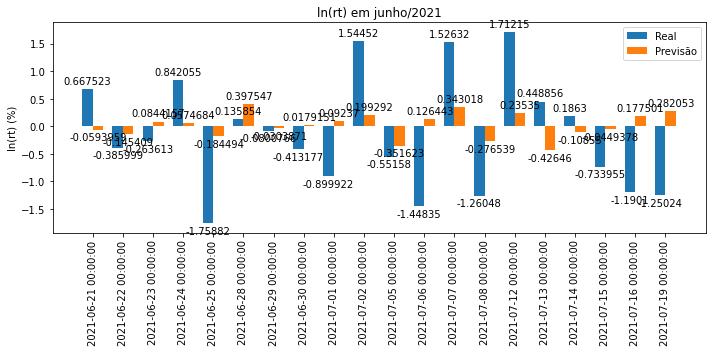

In [60]:
x = np.arange(len(X_real))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, X_real['rt'], width, label='Real')
rects2 = ax.bar(x + width/2, resultado['rt_predict'], width, label='Previsão')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ln(rt) (%)')
ax.set_title('ln(rt) em junho/2021')
ax.set_xticks(x)
ax.set_xticklabels(X_real.index)
plt.xticks(rotation=90)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)


fig.tight_layout()

plt.show()

In [61]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [62]:
print(f"RSME ARIMA:", rmse(resultado['rt_predict'], X_real['rt']))

RSME ARIMA: 0.9866077600490268


In [63]:
rt = dm_test(X_real['rt'],resultado['rt_predict'],X_real['rt'],h = 1, crit="MAD")
print(rt)

dm_return(DM=7.284554661090387, p_value=6.545795435985831e-07)


In [64]:
resultado.loc[resultado['rt_predict'] > 0, 'rt_predict'] = 1
resultado.loc[resultado['rt_predict'] < 0, 'rt_predict'] = 0

In [65]:
X_real.loc[X_real['rt'] > 0, 'rt'] = 1
X_real.loc[X_real['rt'] < 0, 'rt'] = 0

In [66]:
accuracy_score(X_real['rt'], resultado['rt_predict'])

0.55

In [67]:
resultado['rt_predict']

2021-06-21    0.0
2021-06-22    0.0
2021-06-23    1.0
2021-06-24    1.0
2021-06-25    0.0
2021-06-28    1.0
2021-06-29    0.0
2021-06-30    1.0
2021-07-01    1.0
2021-07-02    1.0
2021-07-05    0.0
2021-07-06    1.0
2021-07-07    1.0
2021-07-08    0.0
2021-07-12    1.0
2021-07-13    0.0
2021-07-14    0.0
2021-07-15    0.0
2021-07-16    1.0
2021-07-19    1.0
Name: rt_predict, dtype: float64

In [68]:
X_real['rt']

Date
2021-06-21    1.0
2021-06-22    0.0
2021-06-23    0.0
2021-06-24    1.0
2021-06-25    0.0
2021-06-28    1.0
2021-06-29    0.0
2021-06-30    0.0
2021-07-01    0.0
2021-07-02    1.0
2021-07-05    0.0
2021-07-06    0.0
2021-07-07    1.0
2021-07-08    0.0
2021-07-12    1.0
2021-07-13    1.0
2021-07-14    1.0
2021-07-15    0.0
2021-07-16    0.0
2021-07-19    0.0
Name: rt, dtype: float64